# Disaster Tweets Classification Using Natural Language Processing (NLP)

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

Competition link : https://www.kaggle.com/c/nlp-getting-started/overview

## Evaluation

Submissions are evaluated using F1 between the predicted and expected answers

## Table of Contents

1. Environment Setup
2. Dataset Loading
3. Exploratory Data Analysis (EDA)
4. Text Preprocessing
5. Bag-of-Words (BoW)
6. TF-IDF
7. Machine Learning Model Experimentation
8. Deep Learning Model Experimentation

## Environment Setup

In [1]:
import warnings;
warnings.simplefilter('ignore')
from tqdm import tqdm

# Import SMOTE over-sampling
from imblearn.over_sampling import SMOTE

# Data manipulation libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# NLP libraries
import nltk
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import word_tokenize
import spacy
import en_core_web_sm
nltk.download('punkt')

nlp = en_core_web_sm.load()

# Scikit-Learn libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, plot_roc_curve
from sklearn.model_selection import KFold

# Machine Learning libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant

print("Tensorflow Version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\neela\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tensorflow Version:  2.6.0
Num GPUs Available:  1


## Dataset Loading

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis (EDA)

<AxesSubplot:>

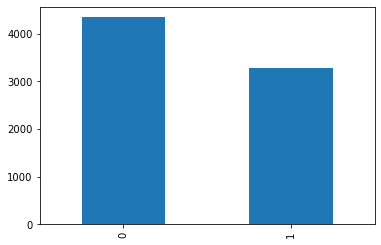

In [4]:
# Class distribution of the dataset

train_df['target'].value_counts().plot(kind='bar')

In [5]:
# Shape of the training dataset

train_df.shape

(7613, 5)

In [6]:
# Shape of the testing dataset

test_df.shape

(3263, 4)

Text(0.5, 1.0, 'Non-Disaster Tweets')

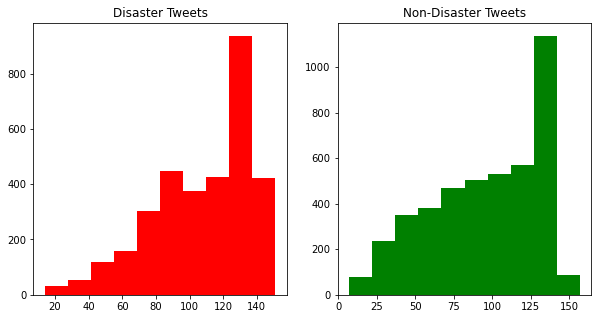

In [7]:
# Length of Disaster and Non-Disaster tweets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

tweet_len_1 = train_df[train_df['target'] == 1]['text'].str.len()
ax1.hist(tweet_len_1, color='red')
ax1.set_title('Disaster Tweets')

tweet_len_2 = train_df[train_df['target'] == 0]['text'].str.len()
ax2.hist(tweet_len_2, color='green')
ax2.set_title('Non-Disaster Tweets')

Text(0.5, 1.0, 'Non-Disaster Tweets')

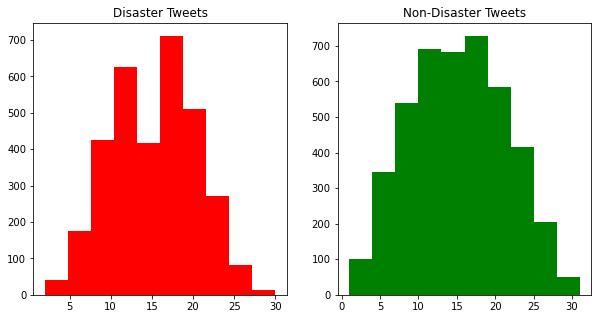

In [8]:
# Number of words in Disaster and Non-Disaster Tweets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_word_1 = train_df[train_df['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_word_1, color='red')
ax1.set_title('Disaster Tweets')

tweet_word_2 = train_df[train_df['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_word_2, color='green')
ax2.set_title('Non-Disaster Tweets')

Text(0.5, 1.0, 'Non-Disaster Tweets')

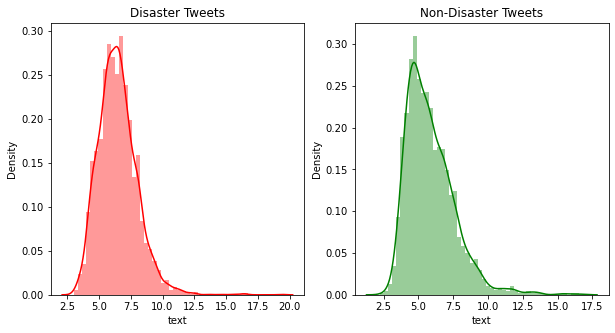

In [9]:
# Average word length in a tweet

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
word_1 = train_df[train_df['target'] == 1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word_1.map(lambda x : np.mean(x)), ax=ax1, color='red')
ax1.set_title('Disaster Tweets')

word_2 = train_df[train_df['target'] == 0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word_2.map(lambda x : np.mean(x)), ax=ax2, color='green')
ax2.set_title('Non-Disaster Tweets')

## Text Preprocessing 

In [10]:
def other_clean(data):
        """
        Manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        data = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], data)
        data = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], data)
        data = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], data)
        
        return data

In [11]:
train_df['text'] = train_df['text'].apply(other_clean)
test_df['text'] = test_df['text'].apply(other_clean)

In [12]:
# Removing punctuations and stop-words from the text data

def _remove_punct(data):
    '''
    This function removes the punctuations from the text
    '''
    return [char for char in data if char.text not in string.punctuation]

def _remove_stopwords(data):
    '''
    This function removes the stopwords from the text
    '''
    return [word for word in data if not word.is_stop]

# Performing Lemmatization on the text data

def _lemmatization(data):
    '''
    This function lemmatizes the text
    '''
    return ' '.join([word.lemma_ for word in data])

# Text Preprocessing pipeline

def _text_preprocess(data):
    '''
    This function will perform the following steps
    1. Normalization 
    2. Remove Punctuations
    3. Remove StopWords
    4 Lemmatization
    '''
    
    # Converting all the text data to its lower form
    data = data.lower()
    
    # Removing URLs from the text data
    data = re.sub(r'https?://\S+|www\.\S+', '', data)
    
    # Removing HTML tags
    data = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", '', data)
    
    # Removing Non-ASCI
    data = re.sub(r'[^\x00-\x7f]','', data)
    
    # Removing Emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    data = emoji_pattern.sub(r'', data)
    
    doc = nlp(data)
    
    # Remove punctuations
    removed_punct = _remove_punct(doc)
    
    # Removed stopwords
    removed_stopwords = _remove_stopwords(removed_punct)
    
    # Lemmatizaion
    lemma = _lemmatization(removed_stopwords)
    
    return lemma

In [13]:
# Preprocessing the text data of training set
train_df['text'] = train_df['text'].apply(_text_preprocess)
test_df['text'] = test_df['text'].apply(_text_preprocess)

## Bag-of-Words (BoW) Model

In [14]:
# Bag-of-Words Model

bow_fit = CountVectorizer().fit(train_df['text'])
bow_transform = bow_fit.transform(train_df['text'])

print('Vocabulary Length : ', len(bow_fit.vocabulary_))

Vocabulary Length :  14535


## TF-IDF Model

In [15]:
# TF-IDF Model

tfidf_fit = TfidfVectorizer().fit(train_df['text'])
tfidf_transform = tfidf_fit.transform(train_df['text'])

## Machine Learning Model Experimentation

In [16]:
# Dataset labels

labels = train_df['target']

In [17]:
# Machine Learning models

model = {'Multinomial Naive Bayes' : MultinomialNB(),
         'K-Nearest Neighbors' : KNeighborsClassifier(n_jobs=-1),
         'Random Forest Classifier' : RandomForestClassifier(n_jobs=-1),
         'Support Vector Machines' : SVC(),
         'Decision Trees' : DecisionTreeClassifier(),
         'Logistic Regression' : LogisticRegression(n_jobs=-1),
         'Gradient Boosting' : GradientBoostingClassifier(),
         'ADA Boosting' : AdaBoostClassifier(),
         'XG Boosting' : XGBClassifier(n_jobs=-1)}

In [18]:
# Model Experimentation Pipeline

def _model_experimentation_pipeline(X, y, models):
    model_score = {}
    for name, model in models.items():
        model_ = model
        print("10-Fold Cross-Validation : ", name)
        
        model_score[name] = np.mean(cross_val_score(model_,
                                              X,
                                              y,
                                              cv=10,
                                              scoring='accuracy',
                                              verbose=2,
                                              n_jobs=-1))
        
    # Converting model_score to DataFrame
    model_score = {'10-Fold CV Score': model_score}
    model_score_df = pd.DataFrame(model_score)
    model_score_df.rename_axis('Model', inplace=True)
    model_score_df.reset_index(inplace=True)
    model_score_df.sort_values('10-Fold CV Score', ascending=False, inplace=True)
    return model_score_df

### Bag-of-Words (BoW) Experimentation

In [19]:
bow_score = _model_experimentation_pipeline(bow_transform, labels, model)
bow_score

10-Fold Cross-Validation :  Multinomial Naive Bayes


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  K-Nearest Neighbors


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Random Forest Classifier


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   29.1s remaining:   29.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Support Vector Machines


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    7.6s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Decision Trees


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Logistic Regression


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Gradient Boosting


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   17.1s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  ADA Boosting


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  XG Boosting


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.3s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.4s finished


,Model,10-Fold CV Score
7,Support Vector Machines,0.679239
5,Multinomial Naive Bayes,0.657958
4,Logistic Regression,0.646007
0,ADA Boosting,0.608954
6,Random Forest Classifier,0.597662
2,Gradient Boosting,0.590044
8,XG Boosting,0.584125
3,K-Nearest Neighbors,0.582690
1,Decision Trees,0.517001


### TF-IDF Experimentation

In [20]:
tfidf_score = _model_experimentation_pipeline(tfidf_transform, labels, model)
tfidf_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


10-Fold Cross-Validation :  Multinomial Naive Bayes
10-Fold Cross-Validation :  K-Nearest Neighbors


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Random Forest Classifier


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   28.3s remaining:   28.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Support Vector Machines


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    7.9s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Decision Trees


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Logistic Regression


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  Gradient Boosting


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   18.1s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


10-Fold Cross-Validation :  ADA Boosting


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.3s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.5s finished


10-Fold Cross-Validation :  XG Boosting


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.4s finished


,Model,10-Fold CV Score
5,Multinomial Naive Bayes,0.693690
4,Logistic Regression,0.687777
7,Support Vector Machines,0.684097
3,K-Nearest Neighbors,0.651919
0,ADA Boosting,0.610004
6,Random Forest Classifier,0.605282
2,Gradient Boosting,0.597663
8,XG Boosting,0.589384
1,Decision Trees,0.529753


## Deep Learning Experimentation

In [21]:
X = train_df['text']
y = train_df['target']

# Splitting the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Text Vectorization Layer

In [22]:
# Maximum number of words in the vocabulary 
max_vocab_length = 10000

# Maximum length of our sequences
max_length = 20

# Creating a text vectorization layer
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

# Fitting our text vectorization layer
text_vectorizer.adapt(X_train)

### Text Embedding Layer

In [23]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128,
                                      input_length=max_length)

## Deep Learning Model Experimentation

In [24]:
# Creating EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

### Model 1 : Feed-Forward Network + Embedding Layer

In [25]:
# Building Model
inputs = tf.keras.layers.Input(shape=(1, ), dtype='string') # Takes 1D string as input
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1')

# Compiling the model
model_1.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['accuracy'])
    
# Generate a print
print('------------------------------------------------------------------------')
print('Model Summary')

model_1.summary()
    
# Training the model
history_1 = model_1.fit(X_train,
                        y_train,
                        batch_size=16,
                        epochs=100,
                        validation_data=(X_test, y_test),
                        verbose=2,
                        callbacks=[early_stopping])

------------------------------------------------------------------------
Model Summary
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 20)                0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 128)           1280000   
_________________________________________________________________
dense (Dense)                (None, 20, 256)           33024     
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
______________________________________

### Model 2 : Recurrent Neural Networks (RNN)(LSTM) + Embedding Layer

In [26]:
# Building the model
inputs = tf.keras.layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.LSTM(256, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2')

# Compiling the model
model_2.compile(loss='binary_crossentropy',
                    optimizer='Adam',
                    metrics=['accuracy'])
    
# Generate a print
print('------------------------------------------------------------------------')
print('Model Summary')
    
# Summary of the model
model_2.summary()

# Training the model
history_2 = model_2.fit(X_train,
                        y_train,
                        batch_size=16,
                        epochs=100,
                        validation_data=(X_test, y_test),
                        verbose=2,
                        callbacks=[early_stopping])

------------------------------------------------------------------------
Model Summary
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 20)                0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 20, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
______________________________________

### Model 3 : Recurrent Neural Networks (RNN)(GRU) + Embedding Layer

In [27]:
# Building the model
inputs = tf.keras.layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(256, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3')

# Compiling the model
model_3.compile(loss='binary_crossentropy',
                    optimizer='Adam',
                    metrics=['accuracy'])

# Generate a print
print('------------------------------------------------------------------------')
print('Model Summary')
    
# Summary of the model
model_3.summary()
    
# Training the model
history_3 = model_3.fit(X_train,
                        y_train,
                        batch_size=16,
                        epochs=100,
                        validation_data=(X_test, y_test),
                        verbose=2,
                        callbacks=[early_stopping])

------------------------------------------------------------------------
Model Summary
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 20)                0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 20, 256)           296448    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
______________________________________

### Model 4 : Recurrent Neural Networks (RNN)(Bi-LSTM) + Embedding Layer

In [ ]:
# Building the model
inputs = tf.keras.layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, outputs, name='model_4')

# Compiling the model
model_4.compile(loss='binary_crossentropy',
                    optimizer='Adam',
                    metrics=['accuracy'])
    
# Summary of the model
model_4.summary()
    
# Training the model
history_4 = model_4.fit(X_train,
                        y_train,
                        batch_size=16,
                        epochs=100,
                        validation_data=(X_test, y_test),
                        verbose=2,
                        callbacks=[early_stopping])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 20)                0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 128)           1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 256)           263168    
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257 

### GloVe Embedding

In [ ]:
# Creating a corpus

def create_corpus_new(data):
    corpus = []
    for tweet in tqdm(data):
        words = [word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

corpus = create_corpus_new(X)
corpus_test = create_corpus_new(test_df['text'])

In [ ]:
# Creating GloVe embedding

embedding_dict={}

with open('glove.6B/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()

In [ ]:
MAX_LEN = 20
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

sequences_test = tokenizer_obj.texts_to_sequences(corpus_test)

tweet_pad = pad_sequences(sequences,
                          maxlen=MAX_LEN,
                          truncating='post',
                          padding='post')

tweet_pad_test = pad_sequences(sequences_test,
                               maxlen=MAX_LEN,
                               truncating='post',
                               padding='post')

In [ ]:
word_index = tokenizer_obj.word_index
print('Number of unique words:', len(word_index))

In [ ]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweet_pad, y, test_size=0.2, random_state=42)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)

### Model 5: Feed-Forward Network + GloVe Embedding

In [ ]:
model_5 = tf.keras.Sequential()

embedding = tf.keras.layers.Embedding(num_words,
                                      100,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=MAX_LEN,
                                      trainable=False)

model_5.add(embedding)
model_5.add(tf.keras.layers.Dense(256, activation='relu'))
model_5.add(tf.keras.layers.Dropout(0.2))
model_5.add(tf.keras.layers.GlobalMaxPooling1D())
model_5.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compiling the model
model_5.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Summary of the model
model_5.summary()

In [ ]:
# Training the model
history_5 = model_5.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        batch_size=16,
                        epochs=100,
                        callbacks=[early_stopping],
                        verbose=2)

In [ ]:
model_5.fit(tweet_pad,
            y,
            epochs=3,
            verbose=2)

In [ ]:
preds = tf.squeeze(tf.round(model_5.predict(tweet_pad_test)))

In [ ]:
pd.read_csv('data/sample_submission.csv').dtypes

In [ ]:
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['target'] = preds
submission['target'] = submission['target'].astype('int')

In [ ]:
submission.dtypes

In [ ]:
submission.to_csv('submission1.csv', index=False)